In [1]:
import numpy as np
import torch
import random

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [17]:
from preprocessing import (
    get_pages,
    get_sentences_per_page,
    get_embeddings_per_page,
)

from sentence_pairs import (
    SentencePairsClassifier,
    SentencePairsDataset,
)

In [3]:
pages = get_pages('cains_jawbone.txt')
sentences = get_sentences_per_page(pages=pages)
embeddings = get_embeddings_per_page(sentences=sentences)

In [19]:
dataset = SentencePairsDataset(embeddings=embeddings)
model = SentencePairsClassifier(layer_sizes=[768, 256, 64, 1])

In [20]:
model

SentencePairsClassifier(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

# Training

In [7]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn

In [21]:
n_epochs = 5
batch_size = 32
optim = Adam(params=model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

losses = []

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1} / {n_epochs}')
    for sentences, labels in dataloader:
        optim.zero_grad()

        preds = model(sentences)
        loss = loss_fn(preds.flatten(), labels)

        loss.backward()
        optim.step()
        losses.append(loss.item())

Epoch 1 / 5
Epoch 2 / 5
Epoch 3 / 5
Epoch 4 / 5
Epoch 5 / 5


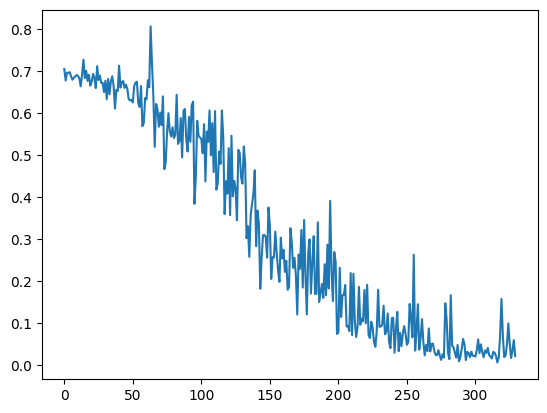

In [22]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [23]:
min(losses)

0.007026857230812311

# Inference

In [24]:
probabilities = {}
model.eval()

for page_number_a, sentences_a in embeddings.items():
    probs = {}

    for page_number_b, sentences_b in embeddings.items():
        if page_number_a == page_number_b:
            continue
        
        t = torch.tensor(
            np.concatenate(
                [sentences_a[-1], sentences_b[0]]
            )
        )
        probs[page_number_b] = model(t).item()
    
    probabilities[page_number_a] = probs



<BarContainer object of 99 artists>

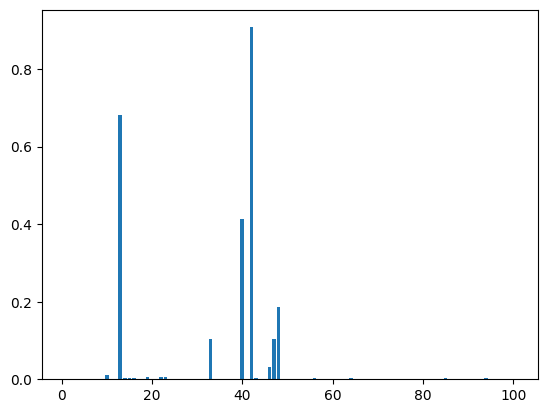

In [26]:
page_a = 60
plt.bar(probabilities[page_a].keys(), probabilities[page_a].values())

In [27]:
start_page = 1
all_pages = list(range(1, 101))
all_pages.remove(start_page)

greedy_order = [start_page]
greedy_probability = 1


while len(all_pages) > 0:
    sorted_probs = sorted(probabilities[greedy_order[-1]].items(), key=lambda x: -x[1])
    i = 0
    while sorted_probs[i][0] in greedy_order:
        i += 1

    next_page = sorted_probs[i][0]
    greedy_probability *= probabilities[greedy_order[-1]][next_page]
    greedy_order.append(next_page)
    all_pages.remove(next_page)

In [28]:
str(greedy_order)

'[1, 42, 13, 33, 48, 23, 46, 47, 19, 40, 22, 15, 70, 92, 10, 95, 53, 99, 11, 64, 83, 14, 43, 39, 66, 3, 55, 28, 9, 36, 100, 56, 98, 16, 94, 17, 4, 85, 34, 44, 27, 77, 20, 21, 72, 25, 37, 45, 35, 51, 58, 75, 32, 71, 82, 49, 30, 97, 78, 84, 86, 68, 59, 41, 74, 7, 52, 89, 2, 50, 93, 38, 54, 62, 79, 61, 90, 29, 76, 31, 65, 60, 57, 88, 69, 73, 87, 5, 67, 63, 91, 6, 80, 81, 96, 18, 24, 12, 8, 26]'